### Import 4MuLa
* update `root_dir_path` below
* 4MuLA Large: 96,458 songs distributed by 15,310 artists in 76 genres
All music are organized by acoustic features in individual folders
* 4MuLA Small: 9,661 songs distributed by 491 artists in 51 genres
Music of Top 500 artists and only melspectrogram as acoustic feature
* 4MuLA Tiny: 1,988 songs distributed by 93 artists in 27 genres
Music of Top 100 artists and only melspectrogram as acoustic feature


In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display
from numpy import argmax
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')
# Update this string to your path
root_dir_path = '/content/drive/MyDrive/'
genres = ['Blues', 'Classic', 'Country', 'Disco', 'Hip Hop', 'Jazz', 'Heavy Metal', "Pop/Rock", "Reggaeton"]
%cd '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


### EDA

In [ ]:
import pandas as pd
df_metadata = pd.read_parquet('4mula_small.parquet')
df_metadata.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music,musicnn_tags,melspectrogram
0,3ade68b6gc207fda3,I've Got To See You Again,en,Line on your face don't bother me\nDown in my ...,3ade68b6gfd79eda3,Norah Jones,353,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Country', 'Ro...","[{'id': '3ade68b6g9a3beda3', 'name': 'Joss Sto...","[{'id': '3ade68b7gdddfcea3', 'name': 'Ten Phan...","['piano','drums','slow']","[[136.96524, 135.869965, 118.730804, 133.62802..."
1,3ade68b8g9410afa3,New Perspective,en,I feel the salty waves come in\nI feel them cr...,3ade68b6g2480fda3,Panic! At The Disco,154,Alternative Rock,"['Rock Alternativo', 'Pop/Punk', 'Pop/Rock', '...","[{'id': '3ade68b6gc5baeda3', 'name': 'Fall Out...","[{'id': '3ade68b7gc6144ea3', 'name': 'Wake Me ...","['rock','pop','guitar']","[[6.28145981, 1.50680351, 0.260610491, 0.17753..."
2,3ade68b7gb67d7ea3,Renúncia,pt-br,Hoje não existe nada mais entre nós\nSomos dua...,3ade68b5gef48eda3,Nelson Gonçalves,446,MPB,"['MPB', 'Velha Guarda', 'Romântico', 'Samba', ...","[{'id': '3ade68b5gf058eda3', 'name': 'Orlando ...","[{'id': '3ade68b6gbab1fda3', 'name': 'As Rosas...","['male','classical','male vocal']","[[0.905277014, 0.33714968, 0.210445538, 0.1545..."
3,3ade68b8gcd12d0b3,Good Form,en,"Eardrummers\nUh, uh, huh, uh, huh\nUh, yo, hol...",3ade68b7gc2b61ea3,Nicki Minaj,421,Rap,"['Rap', 'Pop', 'Hip Hop', 'R&B', 'Dance', 'Ele...","[{'id': '3ade68b5g8d18eda3', 'name': 'Lil Wayn...",[],"['techno','electronic','beat']","[[2.005826, 0.721350968, 0.2188458, 0.23778049..."
4,3ade68b7g955b3ea3,Out Of Time,en,You don't know what's going on\nYou've been aw...,3ade68b6g28c9eda3,Rolling Stones,118,Classic Rock,"['Classic Rock', 'Rock', 'Blues', 'R&B', 'Hard...","[{'id': '3ade68b6g7d5aeda3', 'name': 'Mick Jag...","[{'id': '3ade68b7g9ae20ea3', 'name': 'Run Of T...","['guitar','vocal','drums']","[[0.200993568, 0.232473925, 0.227112547, 0.139..."


In [ ]:
df = df_metadata
df.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music,musicnn_tags,melspectrogram
0,3ade68b6gc207fda3,I've Got To See You Again,en,Line on your face don't bother me\nDown in my ...,3ade68b6gfd79eda3,Norah Jones,353,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Country', 'Ro...","[{'id': '3ade68b6g9a3beda3', 'name': 'Joss Sto...","[{'id': '3ade68b7gdddfcea3', 'name': 'Ten Phan...","['piano','drums','slow']","[[136.96524, 135.869965, 118.730804, 133.62802..."
1,3ade68b8g9410afa3,New Perspective,en,I feel the salty waves come in\nI feel them cr...,3ade68b6g2480fda3,Panic! At The Disco,154,Alternative Rock,"['Rock Alternativo', 'Pop/Punk', 'Pop/Rock', '...","[{'id': '3ade68b6gc5baeda3', 'name': 'Fall Out...","[{'id': '3ade68b7gc6144ea3', 'name': 'Wake Me ...","['rock','pop','guitar']","[[6.28145981, 1.50680351, 0.260610491, 0.17753..."
2,3ade68b7gb67d7ea3,Renúncia,pt-br,Hoje não existe nada mais entre nós\nSomos dua...,3ade68b5gef48eda3,Nelson Gonçalves,446,MPB,"['MPB', 'Velha Guarda', 'Romântico', 'Samba', ...","[{'id': '3ade68b5gf058eda3', 'name': 'Orlando ...","[{'id': '3ade68b6gbab1fda3', 'name': 'As Rosas...","['male','classical','male vocal']","[[0.905277014, 0.33714968, 0.210445538, 0.1545..."
3,3ade68b8gcd12d0b3,Good Form,en,"Eardrummers\nUh, uh, huh, uh, huh\nUh, yo, hol...",3ade68b7gc2b61ea3,Nicki Minaj,421,Rap,"['Rap', 'Pop', 'Hip Hop', 'R&B', 'Dance', 'Ele...","[{'id': '3ade68b5g8d18eda3', 'name': 'Lil Wayn...",[],"['techno','electronic','beat']","[[2.005826, 0.721350968, 0.2188458, 0.23778049..."
4,3ade68b7g955b3ea3,Out Of Time,en,You don't know what's going on\nYou've been aw...,3ade68b6g28c9eda3,Rolling Stones,118,Classic Rock,"['Classic Rock', 'Rock', 'Blues', 'R&B', 'Hard...","[{'id': '3ade68b6g7d5aeda3', 'name': 'Mick Jag...","[{'id': '3ade68b7g9ae20ea3', 'name': 'Run Of T...","['guitar','vocal','drums']","[[0.200993568, 0.232473925, 0.227112547, 0.139..."


In [ ]:
df = df.loc[df['main_genre'].isin(genres)]
df.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music,musicnn_tags,melspectrogram
0,3ade68b6gc207fda3,I've Got To See You Again,en,Line on your face don't bother me\nDown in my ...,3ade68b6gfd79eda3,Norah Jones,353,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Country', 'Ro...","[{'id': '3ade68b6g9a3beda3', 'name': 'Joss Sto...","[{'id': '3ade68b7gdddfcea3', 'name': 'Ten Phan...","['piano','drums','slow']","[[136.96524, 135.869965, 118.730804, 133.62802..."
5,3ade68b8gb59f30b3,Turn It Up,en,But don't be alarmed\nWhen the lights come on\...,3ade68b6g415aeda3,Sean Paul,321,Hip Hop,"['Hip Hop', 'Reggae', 'Rap', 'Black Music', 'D...","[{'id': '3ade68b6g28abeda3', 'name': 'Martin S...",[],"['techno','electronic','beat']","[[0.00925674196, 0.0272453353, 0.433711052, 4...."
8,3ade68b7g69ca3ea3,Ain't Got No/I Got Life,en,"Ain't got no home, ain't got no shoes\nAin't g...",3ade68b6g8529eda3,Nina Simone,429,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Romântico', '...","[{'id': '3ade68b6g11baeda3', 'name': 'Ella Fit...","[{'id': '3ade68b8g9205dfa3', 'name': 'Someone ...","['guitar','male','male vocal']","[[6.49159908, 1.59826362, 0.00176818972, 0.000..."
25,3ade68b7g2ad15ea3,Vivir Sin Aire,es,Como quisiera poder vivir sin aire \nComo quis...,3ade68b5g6847eda3,Maná,480,Pop/Rock,"['Pop/Rock', 'Rock', 'Romântico', 'Pop', 'K-Po...","[{'id': '3ade68b5gea27eda3', 'name': 'Juanes'}...","[{'id': '3ade68b6g394feda3', 'name': 'Corazón ...","['guitar','vocal','slow']","[[622.505798, 543.775146, 474.074524, 208.6196..."
27,3ade68b8gffcd8fa3,Better Today,en,"Whoa oh, whoa oh. \nWhoa oh, whoa oh. \nWhoa o...",3ade68b6g2992fda3,Ne-yo,339,Hip Hop,"['Hip Hop', 'Black Music', 'R&B', 'Pop', 'Danc...","[{'id': '3ade68b6geff9eda3', 'name': 'Justin T...","[{'id': '3ade68b8g89a5bfa3', 'name': 'Talking ...","['pop','electronic','techno']","[[103.667244, 35.9100113, 16.6402645, 21.92423..."


In [ ]:
df["word_count"] = df["music_lyrics"].str.split().str.len()
print(df["word_count"].describe())
mean = 277
std_dev = 195
MIN_WORDS = 100
MAX_WORDS = mean + 3*std_dev

df = df[df["word_count"] <= MAX_WORDS]
df = df[df["word_count"] >= MIN_WORDS]
df.drop("word_count", axis=1)
df = df.reset_index(drop=True)
df.to_csv(f"{root_dir_path}/9_genres_4MuLa_word_count_outliers_removed.csv")
# df.value_counts('main_genre')

<ipython-input-103-550f954266b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["music_lyrics"].str.split().str.len()


count    1049.000000
mean      277.819828
std       194.910263
min         1.000000
25%       151.000000
50%       229.000000
75%       343.000000
max      1680.000000
Name: word_count, dtype: float64


### Baseline Melspectogram CNN (End-to-End)

#### Reshaping the melspectrogram to append to a dataframe for using it in the dataloader
* **n = 932**

In [ ]:
import numpy as np

spectrograms = []
for i in range(len(df)):
  spectrograms.append(np.stack(df['melspectrogram'][i]))

print(f"Spectogram shape: {spectrograms[0].shape}")
df['new_spectrograms'] = spectrograms
# df = df.drop('melspectrogram',axis=1)
train_df = df[['new_spectrograms','main_genre']]
train_df = pd.get_dummies(train_df, columns=['main_genre'])

# remove spectograms less than 30s
train_df_copy = train_df.copy()

for i in range(len(train_df_copy)):
  if train_df_copy['new_spectrograms'][i].shape[1] < 1292:
    train_df_copy = train_df_copy.drop(index=i)

print(f"Dataset size: {train_df_copy.shape[0]}")
train_df_copy.head()

Spectogram shape: (128, 1292)
Dataset size: 932


,new_spectrograms,main_genre_Blues,main_genre_Classic,main_genre_Country,main_genre_Disco,main_genre_Heavy Metal,main_genre_Hip Hop,main_genre_Jazz,main_genre_Pop/Rock,main_genre_Reggaeton
0,"[[136.96524, 135.869965, 118.730804, 133.62802...",False,False,False,False,False,False,True,False,False
1,"[[6.49159908, 1.59826362, 0.00176818972, 0.000...",False,False,False,False,False,False,True,False,False
2,"[[622.505798, 543.775146, 474.074524, 208.6196...",False,False,False,False,False,False,False,True,False
3,"[[103.667244, 35.9100113, 16.6402645, 21.92423...",False,False,False,False,False,True,False,False,False
4,"[[21.2870007, 5.64220524, 0.265555024, 0.65384...",False,False,False,False,False,False,False,True,False


#### Creating a custom dataloader to return the spectrogram and the class label


In [ ]:
genres = ['main_genre_Blues', 'main_genre_Classic', 'main_genre_Country',
          'main_genre_Disco', 'main_genre_Hip Hop', 'main_genre_Jazz',
          'main_genre_Heavy Metal', 'main_genre_Pop/Rock', 'main_genre_Reggaeton']

class CustomImageTextDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seed = 42
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        self.data = self.data.reset_index(drop=True)
        spectrograms = self.data['new_spectrograms'][idx]
        #spectrograms = torch.from_numpy(np.array([x.reshape( (1, 128, 1292) ) for x in spectrograms]))
        spectrograms = torch.tensor(spectrograms, dtype=torch.float32)
        #print(spectrograms.size())
        spectrograms = spectrograms.reshape(1, 128, 1292)
        labels = torch.tensor(self.data[genres].iloc[idx],dtype=torch.float32)
        return spectrograms, labels

train_data = train_df_copy.sample(frac=0.80, random_state=42)
test_data = train_df_copy.sample(frac=0.10, random_state=42)
val_data = train_df_copy.sample(frac=0.10, random_state=42)


traindata = CustomImageTextDataset(
    csv_file=train_data,
)

valdata = CustomImageTextDataset(
    csv_file=val_data,
)

testdata = CustomImageTextDataset(
    csv_file=test_data,
)

# Create a data loader with 32 data points as the batch size
batch_size = 32
train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valdata, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdata, batch_size=batch_size, shuffle=True)

#### Model Definition

In [ ]:
class SpectogramCNN(nn.Module):

    def __init__(self, num_classes):
        super(SpectogramCNN, self).__init__()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride =1 )
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride =1, padding = 'same' )
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5, stride =1, padding = 'same' )

        self.dropout1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(115920, 64)
        self.dropout2 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(64, num_classes)

    def forward(self, x):

        out = nn.functional.relu(self.avgpool(self.conv1(x)))
        out = nn.functional.relu(self.avgpool(self.conv2(out)))
        out = nn.functional.relu(self.avgpool(self.conv3(out)))
        out = torch.flatten(out, start_dim = 1)


        out = self.dropout1(out)

        out = nn.functional.relu(self.linear1(out))
        out = self.dropout2(out)

        out = self.linear2(out)
        #out = F.softmax(out, dim=1)

        return out

#### Training

In [ ]:
def calc_accuracy(model_outputs, targets):
  y_pred = []
  y_true = []
  # calculate accuracy
  try:
    y_pred.extend(model_outputs.cpu().detach().numpy())
    y_true.extend(targets.cpu().detach().numpy())
  except IndexError:
    print(i)
  predictions = []
  for i in y_pred:
    genre = np.argmax(i)
    predictions.append(genres[genre].replace("main_genre_", ""))

  ground_truth = []
  for i in y_true:
    genre = np.argmax(i)
    ground_truth.append(genres[genre].replace("main_genre_", ""))
  return accuracy_score(ground_truth, predictions)

In [ ]:
model = SpectogramCNN(num_classes=len(genres))
model = model.float()

# Transfer Model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

batch_size = 32
epochs = 150
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
best_train_accuracy = 0
best_val_accuracy = 0
for epoch in range(epochs):
    val_accuracy = 0
    train_accuracy = 0
    validation_accuracy.append(val_accuracy)
    training_accuracy.append(train_accuracy)
    ind = len(validation_accuracy)-1

    train_loss = 0.0
    for inputs, targets in train_loader:

            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()
            #print(inputs.size())
            outputs = model(inputs)
            # calculate loss
            # print(outputs.shape)
            loss = criterion(outputs, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            train_loss += loss.item()
            # calculate accuracy
            train_accuracy = calc_accuracy(outputs, targets)
            training_accuracy[ind] = train_accuracy
            best_train_accuracy = train_accuracy if train_accuracy > best_train_accuracy else best_train_accuracy
    val_loss = 0.0
    for inputs, targets in val_loader:

            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                inputs, targets = inputs.cuda(), targets.cuda()

            #print(inputs.size())
            outputs = model(inputs)
            # calculate loss
            # print(outputs.shape)
            loss = criterion(outputs, targets)
            # credit assignment
            loss.backward()
            # update model weights

            val_loss += loss.item()
            # calculate accuracy
            val_accuracy = calc_accuracy(outputs, targets)
            validation_accuracy[ind] = val_accuracy
            # checkpoint (saves the best weights from prev epoch in case of early breakout)
            if val_accuracy > best_val_accuracy:
              best_val_accuracy = val_accuracy
              torch.save(model.state_dict(), '/content/drive/MyDrive/saved_model_SpectogramCNN_10_genres_150ep.pth')
              print(f"Saved best validation accuracy {best_val_accuracy} model")

            if epoch >= 5 and epoch % 5 == 0:
              print(f'Epoch {epoch+1} \t\t Best Validation Accuracy: {best_val_accuracy}')
    # updates metrics
    validation_loss.append(val_loss / len(val_loader))
    training_loss.append(train_loss / len(train_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {val_loss / len(val_loader)}')


    # early breakout
    eps = 1e-6
    val_stop_loss = 1e-1 #0.05
    if len(validation_loss) >= 5 and ((validation_loss[len(validation_loss)-1] - validation_loss[len(validation_loss)-5]) > val_stop_loss) :
      # print(validation_loss[len(validation_loss)-1] - validation_loss[len(validation_loss)-5])
      break

print(f"\033[1mBest Training Accuracy:\033[0m {best_train_accuracy}")
print(f"\033[1mBest Validation Accuracy:\033[0m {best_val_accuracy}")

Saved best validation accuracy 0.5625 model
Saved best validation accuracy 0.6875 model
Saved best validation accuracy 0.7241379310344828 model
Epoch 1 		 Training Loss: 1.8279511332511902 		 Validation Loss: 1.147278110186259
Saved best validation accuracy 0.8275862068965517 model
Epoch 2 		 Training Loss: 1.1577258557081223 		 Validation Loss: 0.9222485820452372
Saved best validation accuracy 0.896551724137931 model
Epoch 3 		 Training Loss: 0.7870325470964114 		 Validation Loss: 0.6990222533543905
Epoch 4 		 Training Loss: 0.48314891445140046 		 Validation Loss: 0.5355083147684733
Epoch 5 		 Training Loss: 0.27626292252292234 		 Validation Loss: 0.5132022798061371
Epoch 6 		 Best Validation Accuracy: 0.896551724137931
Epoch 6 		 Best Validation Accuracy: 0.896551724137931
Epoch 6 		 Best Validation Accuracy: 0.896551724137931
Epoch 6 		 Training Loss: 0.17118583270348608 		 Validation Loss: 0.5683320462703705
Epoch 7 		 Training Loss: 0.307641024235636 		 Validation Loss: 0.48870780

#### Loss Plot

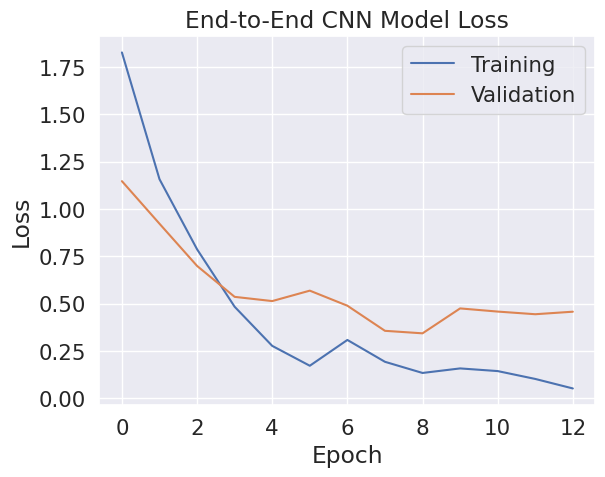

In [ ]:
plt.title("End-to-End CNN Model Loss")
plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Accuracy Plot

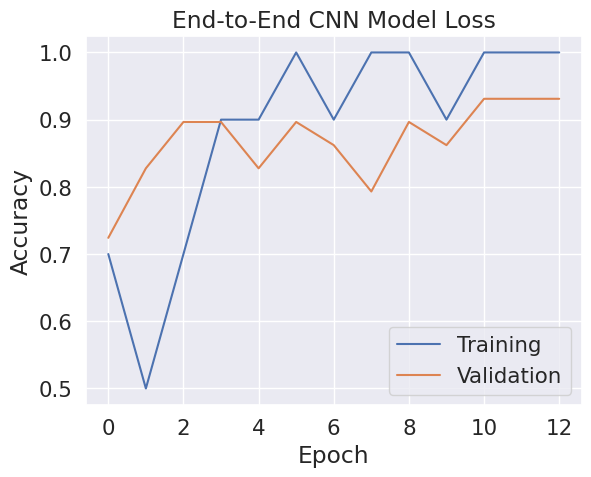

In [ ]:
plt.title("End-to-End CNN Model Loss")
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Testing on the test data and printing evaluation metrics

Testset Accuracy:  0.9354838709677419


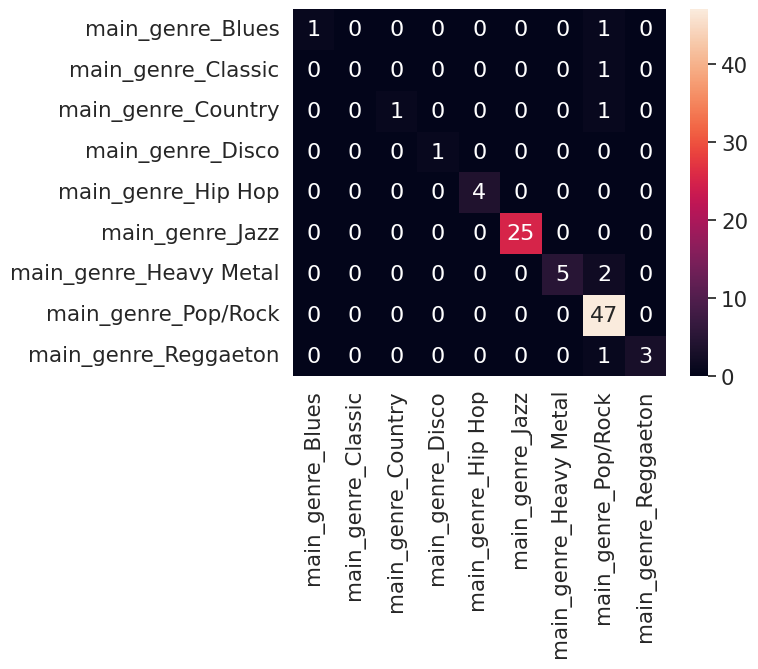

In [ ]:
from sklearn.metrics import accuracy_score
# Evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# best_model = Multimodal_CNN_BERT(num_classes = 10)
# best_model.load_state_dict(torch.load('/content/drive/MyDrive/multi_modal_genre_classifier/saved_model_Multimodal_CNN_BERT_concat_only_10_genres_150ep.pth'))
# best_model.to(device)

best_model = model

best_model.eval()
y_pred = []
y_true = []
i = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        i += 1
        try:
          outputs = best_model(inputs)
          y_pred.extend(outputs.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
        except IndexError:
          print(inputs)
          print(i)
          #print(inputs.shape)

y_pred_edited = []
for i in y_pred:
  genre = np.argmax(i)
  y_pred_edited.append(genres[genre].replace("main_genre_", ""))

y_true_edited = []
for i in y_true:
  genre = np.argmax(i)
  y_true_edited.append(genres[genre].replace("main_genre_", ""))


# confusion matrix
accuracy = accuracy_score(y_true_edited, y_pred_edited)
conf_matrix = confusion_matrix(y_true_edited, y_pred_edited)
# print("predic vs ground truth")
# for i in range(len(ground_truth)):
#   print(predictions[i], ground_truth[i])

conf_matrix = np.round(conf_matrix, 2)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=genres, index=genres)

print(f'\033[1mTestset Accuracy: \033[0m {accuracy}')

plt.figure(figsize = (8,7),)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_df, annot=True, annot_kws={"size": 16},) # font size
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true_edited,y_pred_edited))

              precision    recall  f1-score   support

       Blues       1.00      0.50      0.67         2
     Classic       0.00      0.00      0.00         1
     Country       1.00      0.50      0.67         2
       Disco       1.00      1.00      1.00         1
 Heavy Metal       1.00      1.00      1.00         4
     Hip Hop       1.00      1.00      1.00        25
        Jazz       1.00      0.71      0.83         7
    Pop/Rock       0.89      1.00      0.94        47
   Reggaeton       1.00      0.75      0.86         4

    accuracy                           0.94        93
   macro avg       0.88      0.72      0.77        93
weighted avg       0.93      0.94      0.93        93



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfer-learned + Finetuned VGG-16
https://github.com/Leo-xxx/pytorch-notebooks/blob/master/Torn-shirt-classifier/VGG16-transfer-learning.ipynb

#### Reshaping the melspectrogram to append to a dataframe for using it in the dataloader
* **n = 932**
* makes three channel img dataset

In [ ]:
import numpy as np

spectrograms = []
for i in range(len(df)):
  # make 3 channel images
  spectrograms.append(np.dstack([np.stack(df['melspectrogram'][i]) ]*3))

print(f"Spectogram shape: {spectrograms[0].shape}")
df['new_spectrograms'] = spectrograms
# df = df.drop('melspectrogram',axis=1)
train_df = df[['new_spectrograms','main_genre']]
train_df = pd.get_dummies(train_df, columns=['main_genre'])

# remove spectograms less than 30s
train_df_copy = train_df.copy()

for i in range(len(train_df_copy)):
  if train_df_copy['new_spectrograms'][i].shape[1] < 1292:
    train_df_copy = train_df_copy.drop(index=i)

print(f"Dataset size: {train_df_copy.shape[0]}")
train_df_copy.head()

Spectogram shape: (128, 1292, 3)
Dataset size: 932


,new_spectrograms,main_genre_Blues,main_genre_Classic,main_genre_Country,main_genre_Disco,main_genre_Heavy Metal,main_genre_Hip Hop,main_genre_Jazz,main_genre_Pop/Rock,main_genre_Reggaeton
0,"[[[136.96524, 136.96524, 136.96524], [135.8699...",False,False,False,False,False,False,True,False,False
1,"[[[6.49159908, 6.49159908, 6.49159908], [1.598...",False,False,False,False,False,False,True,False,False
2,"[[[622.505798, 622.505798, 622.505798], [543.7...",False,False,False,False,False,False,False,True,False
3,"[[[103.667244, 103.667244, 103.667244], [35.91...",False,False,False,False,False,True,False,False,False
4,"[[[21.2870007, 21.2870007, 21.2870007], [5.642...",False,False,False,False,False,False,False,True,False


#### Creating a custom dataloader to return the spectrogram and the class label


In [ ]:
genres = ['main_genre_Blues', 'main_genre_Classic', 'main_genre_Country',
          'main_genre_Disco', 'main_genre_Hip Hop', 'main_genre_Jazz',
          'main_genre_Heavy Metal', 'main_genre_Pop/Rock', 'main_genre_Reggaeton']

class CustomImageTextDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seed = 42
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        self.data = self.data.reset_index(drop=True)
        spectrograms = self.data['new_spectrograms'][idx]
        #spectrograms = torch.from_numpy(np.array([x.reshape( (1, 128, 1292) ) for x in spectrograms]))
        spectrograms = torch.tensor(spectrograms, dtype=torch.float32)
        #print(spectrograms.size())
        spectrograms = spectrograms.reshape(3, 128, 1292)
        labels = torch.tensor(self.data[genres].iloc[idx],dtype=torch.float32)
        return spectrograms, labels

train_data = train_df_copy.sample(frac=0.50, random_state=42)
test_data = train_df_copy.sample(frac=0.25, random_state=42)
val_data = train_df_copy.sample(frac=0.25, random_state=42)


traindata = CustomImageTextDataset(
    csv_file=train_data,
)

valdata = CustomImageTextDataset(
    csv_file=val_data,
)

testdata = CustomImageTextDataset(
    csv_file=test_data,
)

# Create a data loader with 32 data points as the batch size
batch_size = 32
train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valdata, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdata, batch_size=batch_size, shuffle=True)

### Load VGG-16

In [355]:
from torchvision import transforms, datasets, models

## Loading VGG16 model
base_model = models.vgg16(pretrained=True)
base_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freeze base model and train classifier head

In [356]:
from torchsummary import summary

# freeze base model and add a new head
for param in base_model.parameters():
  param.requires_grad = False

n_inputs = base_model.classifier[6].in_features

if torch.cuda.is_available():
    base_model = base_model.to('cuda')

# custom head (maybe flatten?)
base_model.classifier[6] = nn.Sequential(
    nn.Flatten(),
    # nn.Dropout(0.4),
    nn.Linear(4096, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(genres)),
    nn.LogSoftmax(dim=1))
if torch.cuda.is_available():
    base_model = base_model.to('cuda')
summary(base_model, input_size=(3, 128, 1292), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [32, 64, 128, 1292]           1,792
              ReLU-2        [32, 64, 128, 1292]               0
            Conv2d-3        [32, 64, 128, 1292]          36,928
              ReLU-4        [32, 64, 128, 1292]               0
         MaxPool2d-5          [32, 64, 64, 646]               0
            Conv2d-6         [32, 128, 64, 646]          73,856
              ReLU-7         [32, 128, 64, 646]               0
            Conv2d-8         [32, 128, 64, 646]         147,584
              ReLU-9         [32, 128, 64, 646]               0
        MaxPool2d-10         [32, 128, 32, 323]               0
           Conv2d-11         [32, 256, 32, 323]         295,168
             ReLU-12         [32, 256, 32, 323]               0
           Conv2d-13         [32, 256, 32, 323]         590,080
             ReLU-14         [32, 256, 

### Training

#### Function def.

In [357]:
def calc_accuracy(model_outputs, targets):
  y_pred = []
  y_true = []
  # calculate accuracy
  try:
    y_pred.extend(model_outputs.cpu().detach().numpy())
    y_true.extend(targets.cpu().detach().numpy())
  except IndexError:
    print(i)
  predictions = []
  for i in y_pred:
    genre = np.argmax(i)
    predictions.append(genres[genre].replace("main_genre_", ""))

  ground_truth = []
  for i in y_true:
    genre = np.argmax(i)
    ground_truth.append(genres[genre].replace("main_genre_", ""))
  return accuracy_score(ground_truth, predictions)

In [358]:
from timeit import default_timer as timer

def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,
          max_epochs_stop=3,n_epochs=20,print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    best_train_accuracy = 0
    best_val_accuracy = 0
    best_model = model

    # Main loop
    for epoch in range(n_epochs):
        model.epochs += 1
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        # train_acc = 0
        # valid_acc = 0

        # Set to training
        model.train()
        start = timer()
        val_accuracy = 0
        train_accuracy = 0
        validation_accuracy.append(val_accuracy)
        training_accuracy.append(train_accuracy)
        ind = len(validation_accuracy)-1

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            # print(output.shape)
            # _, pred = torch.max(output, dim=1)
            # print(pred.shape)
            # correct_tensor = pred.eq(target.data.view_as(pred))
            # # Need to convert correct tensor from int to float to average
            # accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            # train_acc += calc_accuracy(output, target) * data.size(0)
            # calculate accuracy
            train_accuracy += calc_accuracy(output, target) * data.size(0)
            # training_accuracy[ind] = train_accuracy

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')
        training_accuracy[ind] = train_accuracy / len(train_loader.dataset)
        best_train_accuracy = training_accuracy[ind] if training_accuracy[ind] > best_train_accuracy else best_train_accuracy
        # After training loops ends, start validation
        # for epoch in range(n_epochs):

        # validation loop
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                # _, pred = torch.max(output, dim=1)
                # correct_tensor = pred.eq(target.data.view_as(pred))
                # accuracy = torch.mean(
                #     correct_tensor.type(torch.FloatTensor))
                # # Multiply average accuracy times the number of examples
                # valid_acc += calc_accuracy(output, target) * data.size(0)
                # calculate accuracy
                val_accuracy += calc_accuracy(output, target) * data.size(0)
                # validation_accuracy[ind] = val_accuracy
                # best_val_accuracy = val_accuracy if val_accuracy > best_val_accuracy else best_val_accuracy

            # checkpoint
            validation_accuracy[ind] = val_accuracy / len(valid_loader.dataset)
            if validation_accuracy[ind] > best_val_accuracy:
              best_val_accuracy = validation_accuracy[ind]
              print(f'Epoch {epoch+1} \t\t Best Validation Accuracy: {best_val_accuracy}')

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)

            # # Calculate average accuracy
            # train_acc = train_acc / len(train_loader.dataset)
            # valid_acc = valid_acc / len(valid_loader.dataset)

            history.append([train_loss, valid_loss, best_train_accuracy, best_val_accuracy])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * training_accuracy[ind]:.2f}%\t Validation Accuracy: {100 * validation_accuracy[ind]:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss <= valid_loss_min + 0.01:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = best_val_accuracy
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * best_val_accuracy:.2f}%'
                    )
                    print(f"\033[1mBest Training Accuracy:\033[0m {best_train_accuracy}")
                    print(f"\033[1mBest Validation Accuracy:\033[0m {best_val_accuracy}")
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * best_val_accuracy:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

    print(f"\033[1mBest Training Accuracy:\033[0m {best_train_accuracy}")
    print(f"\033[1mBest Validation Accuracy:\033[0m {best_val_accuracy}")

    return model, history


#### Fit to training data

In [359]:
base_model, history = train(
    model=base_model,
    criterion=nn.CrossEntropyLoss(),
    optimizer= optim.Adam(base_model.parameters(), lr = 0.0001, weight_decay=0.1),
    train_loader=train_loader,
    valid_loader=val_loader,
    save_file_name="saved_model_VGG16_10_genres_150ep.pth",
    max_epochs_stop=5,
    n_epochs=150,
    print_every=1
)
# pd.DataFrame(history).plot(figsize=(10, 8))
# plt.show()

Starting Training from Scratch.

Epoch 1 		 Best Validation Accuracy: 0.4678111587982833

Epoch: 0 	Training Loss: 9.9513 	Validation Loss: 4.0931
		Training Accuracy: 38.41%	 Validation Accuracy: 46.78%
Epoch 2 		 Best Validation Accuracy: 0.5579399141630901

Epoch: 1 	Training Loss: 7.9533 	Validation Loss: 2.3886
		Training Accuracy: 37.98%	 Validation Accuracy: 55.79%
Epoch 3 		 Best Validation Accuracy: 0.575107296137339

Epoch: 2 	Training Loss: 3.2545 	Validation Loss: 2.4236
		Training Accuracy: 51.29%	 Validation Accuracy: 57.51%

Epoch: 3 	Training Loss: 2.1149 	Validation Loss: 2.9977
		Training Accuracy: 60.52%	 Validation Accuracy: 53.22%
Epoch 5 		 Best Validation Accuracy: 0.6051502145922747

Epoch: 4 	Training Loss: 1.7563 	Validation Loss: 2.2945
		Training Accuracy: 68.03%	 Validation Accuracy: 60.52%

Epoch: 5 	Training Loss: 1.0106 	Validation Loss: 2.2121
		Training Accuracy: 73.82%	 Validation Accuracy: 59.66%

Epoch: 6 	Training Loss: 0.8733 	Validation Loss: 2.1

#### Loss Plot

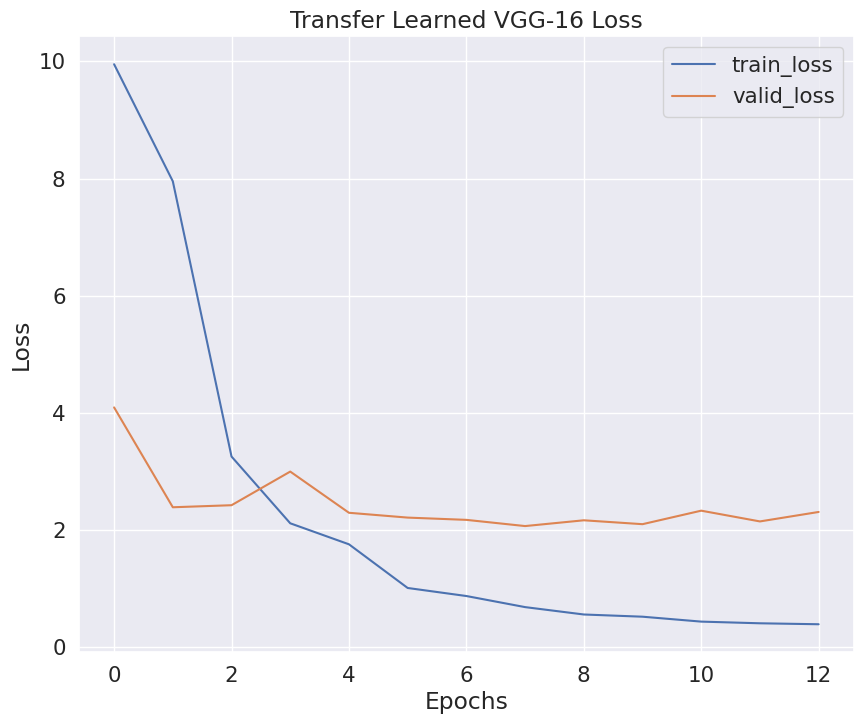

In [360]:
hist_copy = history.copy().drop(["train_acc", "valid_acc"], axis=1)
pd.DataFrame(hist_copy).plot(figsize=(10, 8))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Transfer Learned VGG-16 Loss")
plt.show()

#### Accuracy Plot

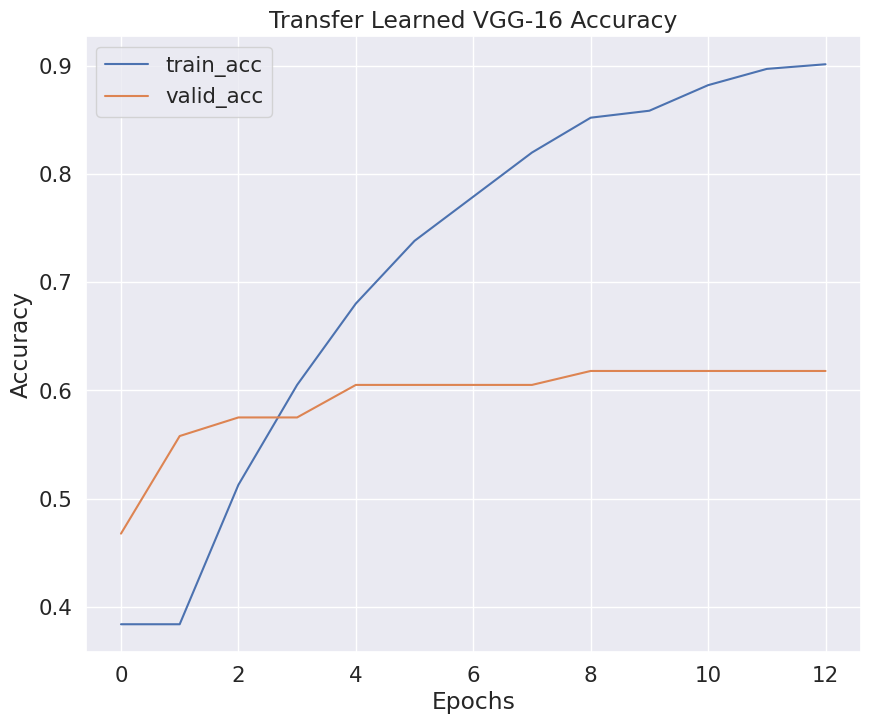

In [361]:
hist_copy = history.copy().drop(["train_loss", "valid_loss"], axis=1)
pd.DataFrame(hist_copy).plot(figsize=(10, 8))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Transfer Learned VGG-16 Accuracy")
plt.show()

#### Evaluate Testset Performance

Testset Accuracy:  0.6051502145922747


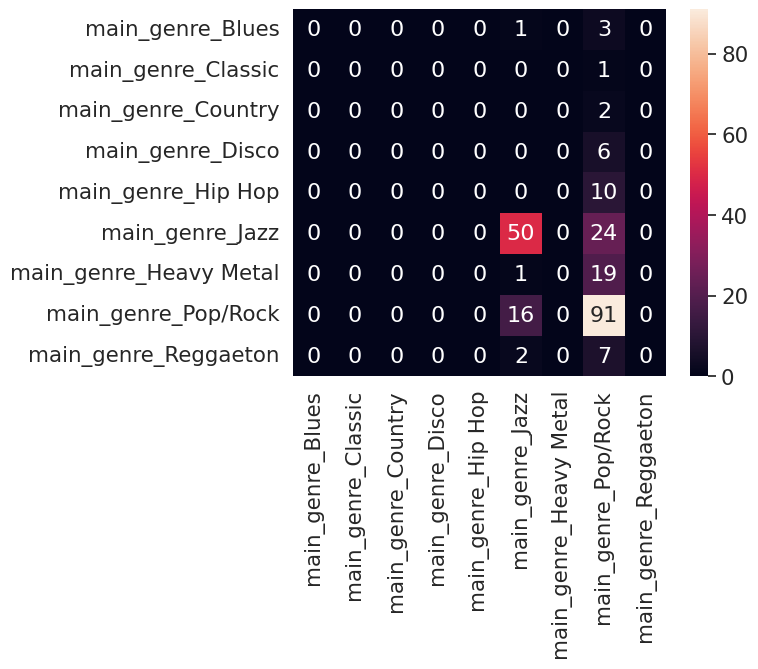

In [362]:
from sklearn.metrics import accuracy_score
# Evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# base_model = Multimodal_CNN_BERT(num_classes = 10)
# base_model.load_state_dict(torch.load(''))
# base_model.to(device)

# best_model = model

base_model.eval()
y_pred = []
y_true = []
i = 0
with torch.no_grad():
    for input, labels in test_loader:
        input, labels = input.to(device), labels.to(device)
        i += 1
        try:
          outputs = base_model(input)
          y_pred.extend(outputs.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
        except IndexError:
          print(input)
          print(i)
          #print(inputs.shape)

y_pred_edited = []
for i in y_pred:
  genre = np.argmax(i)
  y_pred_edited.append(genres[genre].replace("main_genre_", ""))

y_true_edited = []
for i in y_true:
  genre = np.argmax(i)
  y_true_edited.append(genres[genre].replace("main_genre_", ""))


# confusion matrix
accuracy = accuracy_score(y_true_edited, y_pred_edited)
conf_matrix = confusion_matrix(y_true_edited, y_pred_edited)
# print("predic vs ground truth")
# for i in range(len(ground_truth)):
#   print(predictions[i], ground_truth[i])

conf_matrix = np.round(conf_matrix, 2)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=genres, index=genres)

print(f'\033[1mTestset Accuracy: \033[0m {accuracy}')

plt.figure(figsize = (8,7),)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_df, annot=True, annot_kws={"size": 16},) # font size
plt.tight_layout()
plt.show()

## Multimodal: CNN + BERT

### Extracting lyrics to create lyric corpus and downloading the pretrained BERT model

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-multilingual-uncased')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

##### Basic data preprocessing to remove new line character in the corpus

In [ ]:
model = SentenceTransformer('bert-base-multilingual-uncased')
lyric_corpus = df['music_lyrics']
lyric_corpus = [x.replace('\\n', ' ') for x in lyric_corpus]
lyric_embeddings = model.encode(lyric_corpus)
lyric_embeddings_list = [lyric_embeddings[i].tolist() for i in range(len(lyric_embeddings))]

### Exploring mel spectrograms and visualizing a random mel spectrogram

In [ ]:
import librosa
import librosa.display

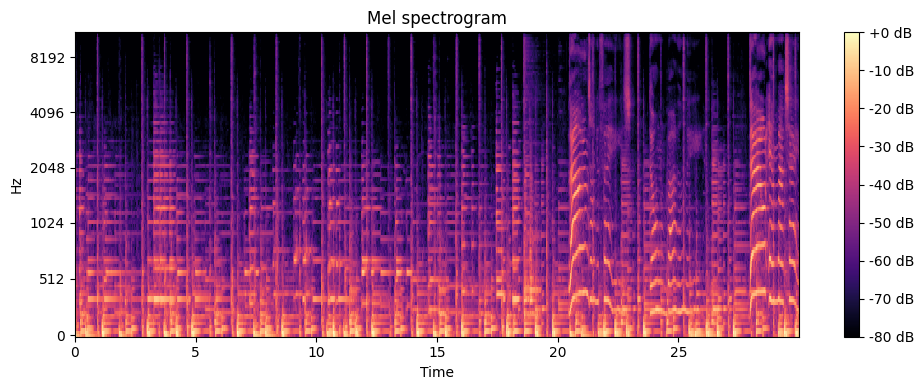

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t = np.stack(df_metadata['melspectrogram'][0])
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(t, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

##### Reshaping the melspectrogram to append to a dataframe for using it in the dataloader

In [ ]:
import numpy as np
spectrograms = []
for i in range(len(df)):
  spectrograms.append(np.stack(df['melspectrogram'][i]))

spectrograms[0].shape

(128, 1292)

Trying to resize the spectograms

(288, 432)

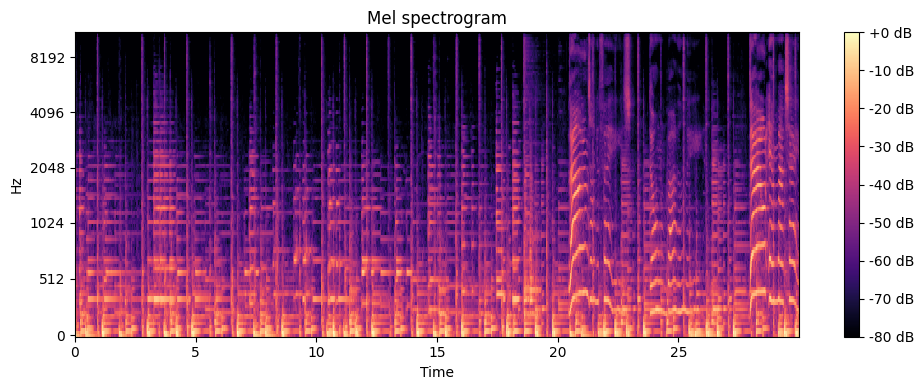

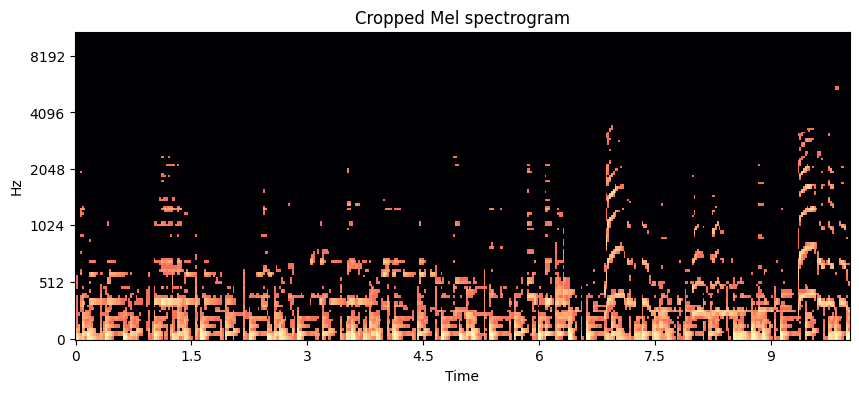

In [ ]:
import cv2
import numpy as np

spect_copy = spectrograms[0].copy()
cv2.imwrite("temp.png", spect_copy)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spect_copy, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()


img = cv2.imread("temp.png", cv2.IMREAD_UNCHANGED)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = np.divide(img, 255)
# print(img)
res = cv2.resize(img, dsize=(432, 288), interpolation=cv2.INTER_NEAREST)
# print(res)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(res, ref=np.max), y_axis='mel', x_axis='time')
# plt.colorbar(format='%+2.0f dB')
plt.title('Cropped Mel spectrogram')
# plt.tight_layout()

# spect_copy = np.resize(spect_copy, (288, 432))
# print(spect_copy[0])
res.shape

In [ ]:
df['new_spectrograms'] = spectrograms
df.head()

,music_id,music_name,music_lang,music_lyrics,art_id,art_name,art_rank,main_genre,related_genre,related_art,related_music,musicnn_tags,melspectrogram,word_count,new_spectrograms
0,3ade68b6gc207fda3,I've Got To See You Again,en,Line on your face don't bother me\nDown in my ...,3ade68b6gfd79eda3,Norah Jones,353,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Country', 'Ro...","[{'id': '3ade68b6g9a3beda3', 'name': 'Joss Sto...","[{'id': '3ade68b7gdddfcea3', 'name': 'Ten Phan...","['piano','drums','slow']","[[136.96524, 135.869965, 118.730804, 133.62802...",121,"[[136.96524, 135.869965, 118.730804, 133.62802..."
1,3ade68b7g69ca3ea3,Ain't Got No/I Got Life,en,"Ain't got no home, ain't got no shoes\nAin't g...",3ade68b6g8529eda3,Nina Simone,429,Jazz,"['Jazz', 'Blues', 'Soul Music', 'Romântico', '...","[{'id': '3ade68b6g11baeda3', 'name': 'Ella Fit...","[{'id': '3ade68b8g9205dfa3', 'name': 'Someone ...","['guitar','male','male vocal']","[[6.49159908, 1.59826362, 0.00176818972, 0.000...",190,"[[6.49159908, 1.59826362, 0.00176818972, 0.000..."
2,3ade68b7g2ad15ea3,Vivir Sin Aire,es,Como quisiera poder vivir sin aire \nComo quis...,3ade68b5g6847eda3,Maná,480,Pop/Rock,"['Pop/Rock', 'Rock', 'Romântico', 'Pop', 'K-Po...","[{'id': '3ade68b5gea27eda3', 'name': 'Juanes'}...","[{'id': '3ade68b6g394feda3', 'name': 'Corazón ...","['guitar','vocal','slow']","[[622.505798, 543.775146, 474.074524, 208.6196...",120,"[[622.505798, 543.775146, 474.074524, 208.6196..."
3,3ade68b8gffcd8fa3,Better Today,en,"Whoa oh, whoa oh. \nWhoa oh, whoa oh. \nWhoa o...",3ade68b6g2992fda3,Ne-yo,339,Hip Hop,"['Hip Hop', 'Black Music', 'R&B', 'Pop', 'Danc...","[{'id': '3ade68b6geff9eda3', 'name': 'Justin T...","[{'id': '3ade68b8g89a5bfa3', 'name': 'Talking ...","['pop','electronic','techno']","[[103.667244, 35.9100113, 16.6402645, 21.92423...",432,"[[103.667244, 35.9100113, 16.6402645, 21.92423..."
4,3ade68b6g0a37fda3,Mais Uma Vez,pt-br,Te tenho com a certeza\nDe que você pode ir\nT...,3ade68b5g6a27eda3,Jota Quest,157,Pop/Rock,"['Pop/Rock', 'Pop', 'Rock', 'Romântico', 'Funk...","[{'id': '3ade68b7ga9891ea3', 'name': 'Ritz'}, ...","[{'id': '3ade68b5g5158eda3', 'name': 'Fogo', '...","['pop','rock','vocal']","[[21.2870007, 5.64220524, 0.265555024, 0.65384...",157,"[[21.2870007, 5.64220524, 0.265555024, 0.65384..."


### Creating the train dataframe which contains the lyrics and the mel spectrograms

In [ ]:
train_df = df[['main_genre','new_spectrograms']]
train_df['lyric_embeddings'] = lyric_embeddings_list
# convert to categorical
train_df = pd.get_dummies(train_df, columns=['main_genre'])
print(train_df.shape)
train_df.head()

<ipython-input-136-a4549486fc9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['lyric_embeddings'] = lyric_embeddings_list


(934, 11)


,new_spectrograms,lyric_embeddings,main_genre_Blues,main_genre_Classic,main_genre_Country,main_genre_Disco,main_genre_Heavy Metal,main_genre_Hip Hop,main_genre_Jazz,main_genre_Pop/Rock,main_genre_Reggaeton
0,"[[136.96524, 135.869965, 118.730804, 133.62802...","[-0.1404007226228714, -0.2850268483161926, 0.3...",False,False,False,False,False,False,True,False,False
1,"[[6.49159908, 1.59826362, 0.00176818972, 0.000...","[-0.332783579826355, -0.40678441524505615, 0.3...",False,False,False,False,False,False,True,False,False
2,"[[622.505798, 543.775146, 474.074524, 208.6196...","[-0.4557594954967499, -0.4749385714530945, 0.2...",False,False,False,False,False,False,False,True,False
3,"[[103.667244, 35.9100113, 16.6402645, 21.92423...","[-0.31090879440307617, -0.2438148409128189, 0....",False,False,False,False,False,True,False,False,False
4,"[[21.2870007, 5.64220524, 0.265555024, 0.65384...","[-0.27269667387008667, -0.19550400972366333, 0...",False,False,False,False,False,False,False,True,False


#### Filtering out spectrograms with shape < 1292 as they are less than 30 seconds
* **n = 932**

In [ ]:
train_df_copy = train_df.copy()

for i in range(len(train_df_copy)):
  if train_df_copy['new_spectrograms'][i].shape[1] < 1292:
    train_df_copy = train_df_copy.drop(index=i)

print(train_df_copy.shape)
train_df_copy.head()

(932, 11)


,new_spectrograms,lyric_embeddings,main_genre_Blues,main_genre_Classic,main_genre_Country,main_genre_Disco,main_genre_Heavy Metal,main_genre_Hip Hop,main_genre_Jazz,main_genre_Pop/Rock,main_genre_Reggaeton
0,"[[136.96524, 135.869965, 118.730804, 133.62802...","[-0.1404007226228714, -0.2850268483161926, 0.3...",False,False,False,False,False,False,True,False,False
1,"[[6.49159908, 1.59826362, 0.00176818972, 0.000...","[-0.332783579826355, -0.40678441524505615, 0.3...",False,False,False,False,False,False,True,False,False
2,"[[622.505798, 543.775146, 474.074524, 208.6196...","[-0.4557594954967499, -0.4749385714530945, 0.2...",False,False,False,False,False,False,False,True,False
3,"[[103.667244, 35.9100113, 16.6402645, 21.92423...","[-0.31090879440307617, -0.2438148409128189, 0....",False,False,False,False,False,True,False,False,False
4,"[[21.2870007, 5.64220524, 0.265555024, 0.65384...","[-0.27269667387008667, -0.19550400972366333, 0...",False,False,False,False,False,False,False,True,False


### Creating a custom dataloader to get the outputs of lyrics, spectrograms and genres

In [363]:
genres = ['main_genre_Blues', 'main_genre_Classic', 'main_genre_Country',
          'main_genre_Disco', 'main_genre_Hip Hop', 'main_genre_Jazz',
          'main_genre_Heavy Metal', 'main_genre_Pop/Rock', 'main_genre_Reggaeton']
class CustomImageTextDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seed = 42
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        self.data = self.data.reset_index(drop=True)
        lyrics = self.data['lyric_embeddings'][idx]
        lyrics = torch.tensor(lyrics, dtype=torch.float32)
        spectrograms = self.data['new_spectrograms'][idx]
        spectrograms = torch.tensor(spectrograms, dtype=torch.float32)
        #print(spectrograms.size())
        spectrograms = spectrograms.reshape(1, 128, 1292)
        labels = torch.tensor(self.data[genres].iloc[idx],dtype=torch.float32)
        return lyrics, spectrograms, labels

train_data = train_df_copy.sample(frac=0.80, random_state=42)
val_data = train_df_copy.sample(frac=0.10, random_state=42)
test_data = train_df_copy.sample(frac=0.10, random_state=42)


traindata = CustomImageTextDataset(
    csv_file=train_data,
)

valdata = CustomImageTextDataset(
    csv_file=val_data
)

testdata = CustomImageTextDataset(
    csv_file=test_data,
)

kfolddata = CustomImageTextDataset(
    csv_file=train_df_copy
)

# Create a data loader with 32 data points as the batch size
batch_size = 32
train_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testdata, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valdata, batch_size=batch_size, shuffle=True)
kfold_loader = DataLoader(kfolddata, batch_size=batch_size, shuffle=True)

### Defining our concatentation based Multimodal_CNN_BERT classifier

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import numpy as np
from numpy import argmax
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn.functional as F


class Multimodal_CNN_BERT(nn.Module):

    def __init__(self, num_classes):
        super(Multimodal_CNN_BERT, self).__init__()
        self.num_classes = num_classes
        self.spectrogram_network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride =1),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5, stride =1, padding = 'same' ),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5, stride =1, padding = 'same' ),
            nn.AvgPool2d(2, stride=2)
        )

        self.lyric_network = nn.Sequential(
            nn.Linear(768, 512),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.Dropout(p=0.3),
        )

        self.fusion_layer = nn.Sequential(
            nn.Linear(116176, 256),
            nn.ReLU()
        )
        self.linear1 = nn.Linear(256,128)
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64,num_classes)

    def forward(self, lyrics, spec):
        spectrogram_emb = self.spectrogram_network(spec)
        spectrogram_emb = spectrogram_emb.view(spec.size(0), -1)
        lyric_emb = self.lyric_network(lyrics)
        x = torch.cat((spectrogram_emb,lyric_emb),dim=1)
        x = self.fusion_layer(x)
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        out = torch.relu(self.linear3(x))
        #out = F.softmax(out, dim=1)
        return out

### Performing training for 150 epochs with a learnin rate of 0.0001 and Adam optimizer. We save the model weights to perform evaluation in the future

#### Function Def.

In [ ]:
def calc_accuracy(model_outputs, targets):
  y_pred = []
  y_true = []
  # calculate accuracy
  try:
    y_pred.extend(model_outputs.cpu().detach().numpy())
    y_true.extend(targets.cpu().detach().numpy())
  except IndexError:
    print(i)
  predictions = []
  for i in y_pred:
    genre = np.argmax(i)
    predictions.append(genres[genre].replace("main_genre_", ""))

  ground_truth = []
  for i in y_true:
    genre = np.argmax(i)
    ground_truth.append(genres[genre].replace("main_genre_", ""))
  return accuracy_score(ground_truth, predictions)

In [ ]:
model = Multimodal_CNN_BERT(num_classes = len(genres))
model = model.float()

# Transfer Model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

batch_size = 32
epochs = 150
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
best_train_accuracy = 0
best_val_accuracy = 0
best_model = model

for epoch in range(epochs):
    val_accuracy = 0
    train_accuracy = 0
    validation_accuracy.append(val_accuracy)
    training_accuracy.append(train_accuracy)
    ind = len(validation_accuracy)-1

    train_loss = 0.0
    for lyrics, spectrograms, targets in train_loader:

            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                lyrics, spectrograms, targets = lyrics.cuda(), spectrograms.cuda(), targets.cuda()

            optimizer.zero_grad()
            #print(inputs.size())
            outputs = model(lyrics, spectrograms)
            # calculate loss
            # print(outputs.shape)
            loss = criterion(outputs, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            train_loss += loss.item()
            # calculate accuracy
            train_accuracy = calc_accuracy(outputs, targets)
            training_accuracy[ind] = train_accuracy
            best_train_accuracy = train_accuracy if train_accuracy > best_train_accuracy else best_train_accuracy
    val_loss = 0.0
    for lyrics, spectrograms, targets in val_loader:

            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                lyrics, spectrograms, targets = lyrics.cuda(), spectrograms.cuda(), targets.cuda()

            #print(inputs.size())
            outputs = model(lyrics, spectrograms)
            # calculate loss
            # print(outputs.shape)
            loss = criterion(outputs, targets)
            # credit assignment
            loss.backward()
            # update model weights

            val_loss += loss.item()
            # calculate accuracy
            val_accuracy = calc_accuracy(outputs, targets)
            validation_accuracy[ind] = val_accuracy
            # best_val_accuracy = val_accuracy if val_accuracy > best_val_accuracy else best_val_accuracy

            # checkpoint
            if val_accuracy > best_val_accuracy:
              best_val_accuracy = val_accuracy
              torch.save(model.state_dict(), '/content/drive/MyDrive/saved_model_Multimodal_CNN_BERT_concat_only_10_genres_150ep.pth')
              print(f"Saved best validation accuracy {best_val_accuracy} model")
              best_model = model
            if epoch >= 5 and epoch % 5 == 0:
              print(f'Epoch {epoch+1} \t\t Best Validation Accuracy: {best_val_accuracy}')
    # updates metrics
    validation_loss.append(val_loss / len(val_loader))
    training_loss.append(train_loss / len(train_loader))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {val_loss / len(val_loader)}')

    # early breakout
    eps = 1e-6
    val_stop_loss = 0.05 #0.05
    if len(validation_loss) >= 5 and ((validation_loss[len(validation_loss)-1] - validation_loss[len(validation_loss)-5]) > val_stop_loss) :
      # print(validation_loss[len(validation_loss)-1] - validation_loss[len(validation_loss)-5])
      break


    # # early breakout
    # eps = 1e-6
    # if len(training_loss) >= 2 and abs(training_loss[len(training_loss)-1] - training_loss[len(training_loss)-2]) < eps:
    #   break

print(f"\033[1mBest Training Accuracy:\033[0m {best_train_accuracy}")
print(f"\033[1mBest Validation Accuracy:\033[0m {best_val_accuracy}")

Saved best validation accuracy 0.53125 model
Saved best validation accuracy 0.625 model
Epoch 1 		 Training Loss: 1.7353126555681229 		 Validation Loss: 1.3795459667841594
Saved best validation accuracy 0.71875 model
Saved best validation accuracy 0.8275862068965517 model
Epoch 2 		 Training Loss: 1.1806548461318016 		 Validation Loss: 0.9379527568817139
Epoch 3 		 Training Loss: 0.9017653912305832 		 Validation Loss: 0.8200979232788086
Saved best validation accuracy 0.8620689655172413 model
Epoch 4 		 Training Loss: 0.7274261663357416 		 Validation Loss: 0.7148512899875641
Saved best validation accuracy 0.896551724137931 model
Epoch 5 		 Training Loss: 0.5731827927132448 		 Validation Loss: 0.6170505185921987
Epoch 6 		 Best Validation Accuracy: 0.896551724137931
Epoch 6 		 Best Validation Accuracy: 0.896551724137931
Epoch 6 		 Best Validation Accuracy: 0.896551724137931
Epoch 6 		 Training Loss: 0.4865879776577155 		 Validation Loss: 0.5074119369188944
Epoch 7 		 Training Loss: 0.426

#### Loss Plot

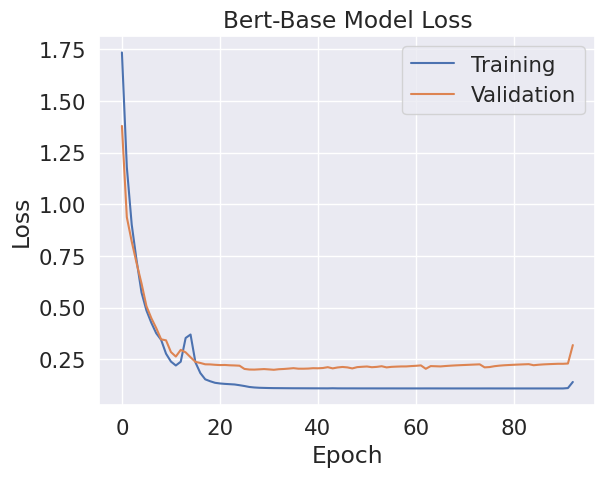

In [ ]:
plt.title("Bert-Base Model Loss")
plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Accuracy Plot

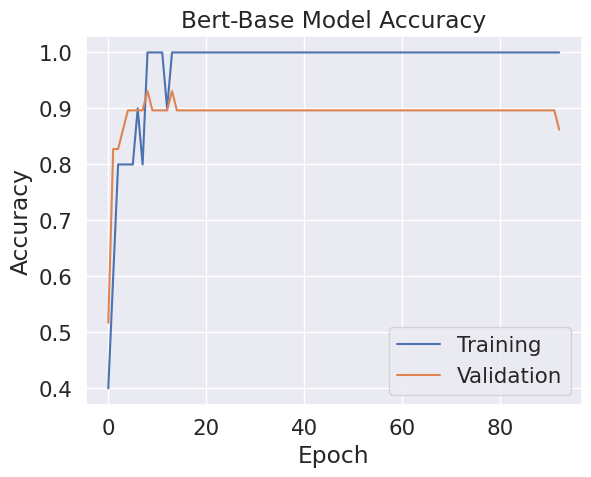

In [ ]:
plt.title("Bert-Base Model Accuracy")
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Testing on the test data and printing evaluation metrics

Testset Accuracy:  0.9032258064516129


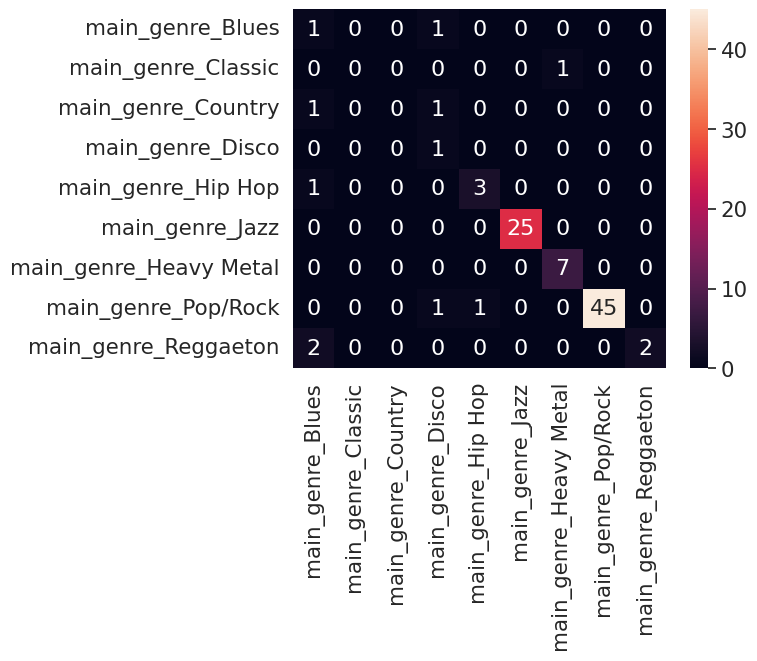

In [ ]:
from sklearn.metrics import accuracy_score
# Evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# best_model = Multimodal_CNN_BERT(num_classes = 10)
# best_model.load_state_dict(torch.load('/content/drive/MyDrive/multi_modal_genre_classifier/saved_model_Multimodal_CNN_BERT_concat_only_10_genres_150ep.pth'))
# best_model.to(device)

# best_model = model

best_model.eval()
y_pred = []
y_true = []
i = 0
with torch.no_grad():
    for lyrics, spectrograms, labels in test_loader:
        lyrics, spectrograms, labels = lyrics.to(device), spectrograms.to(device), labels.to(device)
        i += 1
        try:
          outputs = best_model(lyrics, spectrograms)
          y_pred.extend(outputs.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
        except IndexError:
          print(lyrics, spectrograms)
          print(i)
          #print(inputs.shape)

y_pred_edited = []
for i in y_pred:
  genre = np.argmax(i)
  y_pred_edited.append(genres[genre].replace("main_genre_", ""))

y_true_edited = []
for i in y_true:
  genre = np.argmax(i)
  y_true_edited.append(genres[genre].replace("main_genre_", ""))


# confusion matrix
accuracy = accuracy_score(y_true_edited, y_pred_edited)
conf_matrix = confusion_matrix(y_true_edited, y_pred_edited)
# print("predic vs ground truth")
# for i in range(len(ground_truth)):
#   print(predictions[i], ground_truth[i])

conf_matrix = np.round(conf_matrix, 2)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=genres, index=genres)

print(f'\033[1mTestset Accuracy: \033[0m {accuracy}')

plt.figure(figsize = (8,7),)
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_df, annot=True, annot_kws={"size": 16},) # font size
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true_edited,y_pred_edited))

              precision    recall  f1-score   support

       Blues       0.20      0.50      0.29         2
     Classic       0.00      0.00      0.00         1
     Country       0.00      0.00      0.00         2
       Disco       0.25      1.00      0.40         1
 Heavy Metal       0.75      0.75      0.75         4
     Hip Hop       1.00      1.00      1.00        25
        Jazz       0.88      1.00      0.93         7
    Pop/Rock       1.00      0.96      0.98        47
   Reggaeton       1.00      0.50      0.67         4

    accuracy                           0.90        93
   macro avg       0.56      0.63      0.56        93
weighted avg       0.92      0.90      0.90        93



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import KFold
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
# dataset = torch.utils.data.ConcatDataset
splits = KFold(n_splits=5, shuffle=True, random_state=42)